# 주요 질병 사망자 및 보건 환경 비교 분석
## - 5 - 공공사회 복지 지출
(Comparative Analysis of Major Disease Deaths and Health Environment)
## 1. 소개
국가별 의료 관련 데이터들을 이용해, 국가별, 연간 질병 사망자 수와 의료 인프라 간의 관계를 분석해보고 시각화를 해본 프로젝트

## 2. 목표
- 각 데이터의 EDA와 시각화
- 비슷한 분류의 데이터를 하나로 합치기
- 의료 인프라와 질병 사망자 수 관계 찾기 및 분석

## 3. 데이터 셋
- [KOSIS 10만명당 주요사망원인별 사망률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&conn_path=I2)
- [KOSIS 의료종사자수](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC01&conn_path=I2)
- [KOSIS 보건관련 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC09&conn_path=I2)
- [KOSIS 보건서비스 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC14&conn_path=I2)
- [KOSIS 의약품 판매](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC25&conn_path=I2)
- [KOSIS 의약품 소비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC24&conn_path=I2)
- [KOSIS 공공사회복지 지출](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAD21&conn_path=I2)
- [geojson 데이터](https://github.com/dr5hn/countries-states-cities-database/blob/master/countries.json)

## 4. 구현

#### 라이브러리

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cufflinks as cf
import folium
from folium.plugins import MarkerCluster
import json

#### 한글 폰트 설정

In [2]:
from IPython.display import set_matplotlib_formats

def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

get_font_family()

plt.style.use("ggplot")

font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc("axes", unicode_minus=False)

set_matplotlib_formats("retina")

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: ca

In [3]:
# 모든 데이터 공통 국가
country_intersection = ['룩셈부르크',  '네덜란드',  '영국',  '이탈리아',  '캐나다',  '오스트레일리아',  '한국',  '일본',  '스페인',  '헝가리',  '독일',  '에스토니아',  '그리스',  '슬로바키아',  '핀란드',  '벨기에',  '체코',  '슬로베니아',  '프랑스',  '스웨덴',  '노르웨이',  '뉴질랜드',  '라트비아',  '덴마크',  '오스트리아',  '포르투갈',  '아일랜드',  '아이슬란드']

### 5. 공공사회 복지 지출

#### Data Load

In [4]:
# #드라이브에 접근할 수 있도록 아래 코드 입력
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# 코랩용
# expense_filename = '/content/drive/MyDrive/Colab Notebooks/공공사회복지_지출_20220608224432_분석(전년_대비_증감)_이슬.csv'
# insurance_filename = '/content/drive/MyDrive/Colab Notebooks/사회보험부담률_GDP_대비__20220609001721_분석(전년_대비_증감)_이슬2.csv'
# sercvice_filename = '/content/drive/MyDrive/보건서비스_지출비_20220609140138_분석(전년_대비_증감).csv'
# oecd_gdp_filename = '/content/drive/MyDrive/Colab Notebooks/OECD_국가의_주요지표_20220610085126.csv'
# exchange_rate_filename = '/content/drive/MyDrive/Colab Notebooks/환율_OECD__20220610100348.csv'

In [6]:
# 코랩 외, 파일 저장 후 불러오기 할 경우
expense_filename = '공공사회복지_지출_20220608224432_분석(전년_대비_증감)_이슬.csv'
# insurance_filename = '사회보험부담률_GDP_대비__20220609001721_분석(전년_대비_증감)_이슬2.csv'
sercvice_filename = '보건서비스_지출비_20220609140138_분석(전년_대비_증감).csv'
oecd_gdp_filename = 'OECD_국가의_주요지표_20220610085126.csv'
exchange_rate_filename = '환율_OECD__20220610100348.csv'

##### GDP/환율 데이터 전처리 (본 데이터 세 개 전처리에 사용예정)
    1. GDP datafraeme : df_gdp (key_gdp 기준 나중에 merge)
    2. 환율 dataframe : currency_rate (key_currency 기준 나중에 merge)

In [7]:
#pandas read_csv로 불러오기
oecd_gdp = pd.read_csv(oecd_gdp_filename, encoding = 'cp949')
oecd_gdp.head(2)

,시점,항목,국가별(1),국가별(2),데이터
0,1998,국내총생산(GDP)(당해년 가격) (10억US$),아시아,한국,384.0
1,1998,국내총생산(GDP)(당해년 가격) (10억US$),아시아,이스라엘,116.2


In [8]:
#pandas read_csv로 불러오기 (원데이터 단위 : 대미달러)
exchange_rate = pd.read_csv(exchange_rate_filename, encoding = 'cp949')
exchange_rate.head(2)

,시점,국가(통화단위)별(1),국가(통화단위)별(2),데이터
0,1998,아시아,한국(Won),1394.97
1,1998,아시아,이스라엘(New Sheqalim),3.80


In [9]:
# 컬럼명 변경
# GDP
cols_gdp = ['연도', '항목', '대륙', '국가', '값(10억$)']
oecd_gdp.columns = cols_gdp
# 환율
exchange_rate.columns = ['연도', '대륙', '국가', '환율(자국화폐단위/$)']
# 확인
oecd_gdp.head(2), exchange_rate.head(2)

(     연도                           항목   대륙    국가  값(10억$)
 0  1998  국내총생산(GDP)(당해년 가격) (10억US$)  아시아    한국    384.0
 1  1998  국내총생산(GDP)(당해년 가격) (10억US$)  아시아  이스라엘    116.2,
      연도   대륙                  국가  환율(자국화폐단위/$)
 0  1998  아시아             한국(Won)       1394.97
 1  1998  아시아  이스라엘(New Sheqalim)          3.80)

In [10]:
# GDP '공통국가여부' 컬럼 추가
oecd_gdp.loc[oecd_gdp['국가'].isin(country_intersection), '공통국가여부'] = '공통'
oecd_gdp['공통국가여부'] = oecd_gdp['공통국가여부'].fillna('해당아님')
oecd_gdp['공통국가여부'].unique()

array(['공통', '해당아님'], dtype=object)

In [11]:
# GDP 컬럼 순서 변경
cols_gdp = ['대륙', '국가','공통국가여부', '항목', '연도','값(10억$)']
oecd_gdp = oecd_gdp[cols_gdp]

In [12]:
# 뒤에서 사회복지지출/보험부담률 % > 금액으로 통일시킬 떄 사용할 key값 생성
oecd_gdp['key_gdp'] = oecd_gdp['국가']+oecd_gdp['연도'].astype(str)

In [13]:
# 최종적으로 사용할 GDP dataframe
df_gdp = oecd_gdp.iloc[:,-2:]
df_gdp = df_gdp[['key_gdp', '값(10억$)']] 
df_gdp.columns = ['key_gdp', 'GDP(10억$)']
df_gdp.head(2)

,key_gdp,GDP(10억$)
0,한국1998,384.0
1,이스라엘1998,116.2


In [14]:
# 환율 : null값/0값 확인 : 없음
exchange_rate['환율(자국화폐단위/$)'].isnull().sum(), len(exchange_rate[exchange_rate['환율(자국화폐단위/$)']==0.0])

(0, 0)

In [15]:
# 리스트 생성
list_temp = exchange_rate['국가'].tolist()
list_temp = [nation.split("(")[0] for nation in list_temp]
len(list_temp) == len(exchange_rate)
list_temp[:3] 


['한국', '이스라엘', '일본']

In [16]:
# 뒤에서 복지서비스 지출, 단위 통일시킬 떄 사용할 key값 생성
exchange_rate['국가'] = pd.DataFrame(list_temp)
exchange_rate['key_currency'] = exchange_rate['연도'].astype(str)+exchange_rate['국가']
exchange_rate.sample(2)


,연도,대륙,국가,환율(자국화폐단위/$),key_currency
54,1999,유럽,라트비아,0.59,1999라트비아
119,2001,오세아니아,오스트레일리아,1.93,2001오스트레일리아


In [17]:
# 최종적으로 사용할 환율 dataframe
currency_rate = exchange_rate[['key_currency', '환율(자국화폐단위/$)']]
currency_rate.head()

,key_currency,환율(자국화폐단위/$)
0,1998한국,1394.97
1,1998이스라엘,3.80
2,1998일본,130.91
3,1998터키,0.26
4,1998캐나다,1.48


##### 공공사회복지지출 dataframe 전처리 > df_welfare 사용하면 됨
    1. 컬럼명 변경
    2. 공통국가(28개국) 컬럼 생성
    3. 연도/국가 별 gdp 데이터 이용 : % of gdp > 금액 기준 변환

In [18]:
# 공공사회복지지출
#pandas read_csv로 불러오기 (원데이터 단위 : % of GDP)
welfare_exp = pd.read_csv(expense_filename, encoding = 'cp949')
welfare_exp.head(2)

,국가별(1),국가별(2),시점,원데이터,전년 대비 증감
0,아시아,소계,1998,NaN,NaN
1,아시아,소계,1999,NaN,NaN


In [19]:
# 1. 컬럼명 변경
cols_wel = ['대륙', '국가','연도', '값(% of gdp)', '전년대비증감']
welfare_exp.columns = cols_wel

In [20]:
# 2. 각 데이터 '공통국가여부' 컬럼 추가
welfare_exp.loc[welfare_exp['국가'].isin(country_intersection), '공통국가여부'] = '공통'
welfare_exp['공통국가여부'] = welfare_exp['공통국가여부'].fillna('해당아님')
welfare_exp.shape, welfare_exp['공통국가여부'].unique()

((893, 6), array(['해당아님', '공통'], dtype=object))

In [21]:
# 컬럼 순서 변경
cols_wel = ['대륙', '국가','공통국가여부','연도', '값(% of gdp)', '전년대비증감']
welfare_exp = welfare_exp[cols_wel]

In [22]:
# 원본 냅두고 copy해서 만들어줄거임

In [23]:
df_welfare = welfare_exp.copy()
df_welfare.shape == welfare_exp.shape

True

In [24]:
# 3. % of gdp > 금액 환산 위해 : key  값 생성 + merge
df_welfare['key_gdp'] = df_welfare['국가']+df_welfare['연도'].astype(str)
df_welfare = df_welfare.merge(right = df_gdp, how = 'left', on = 'key_gdp')
df_welfare.sample(3)

,대륙,국가,공통국가여부,연도,값(% of gdp),전년대비증감,key_gdp,GDP(10억$)
52,아시아,이스라엘,해당아님,2006,15.2,-0.2,이스라엘2006,154.2
34,아시아,한국,공통,2010,7.9,-0.2,한국2010,1143.9
430,유럽,독일,공통,2014,24.8,-0.1,독일2014,3883.9


In [25]:
df_welfare['복지비용(10억$)'] = df_welfare['값(% of gdp)'] * df_welfare['GDP(10억$)']
df_welfare.head(3)

,대륙,국가,공통국가여부,연도,값(% of gdp),전년대비증감,key_gdp,GDP(10억$),복지비용(10억$)
0,아시아,소계,해당아님,1998,NaN,NaN,소계1998,NaN,NaN
1,아시아,소계,해당아님,1999,NaN,NaN,소계1999,NaN,NaN
2,아시아,소계,해당아님,2000,NaN,NaN,소계2000,NaN,NaN


##### 사회보험부담률 dataframe 전처리 > df_insurance 사용하면 됨
    1. 컬럼명 변경
    2. 공통국가(28개국) 컬럼 생성
    3. 연도/국가 별 gdp 데이터 이용 : % of gdp > 금액 기준 변환

In [26]:
# 사회보험부담률
#pandas read_csv로 불러오기 (원데이터 단위 : % of GDP)
# insu_per_gdp = pd.read_csv(insurance_filename, encoding = 'cp949')
# insu_per_gdp.head(2)


In [27]:
# 1. 컬럼명 변경
# cols_insu = ['대륙', '국가','연도', '값(% of gdp)', '전년대비증감']
# insu_per_gdp.columns = cols_insu

In [28]:
# # 2. 각 데이터 '공통국가여부' 컬럼 추가
# insu_per_gdp.loc[insu_per_gdp['국가'].isin(country_intersection), '공통국가여부'] = '공통'
# insu_per_gdp['공통국가여부'] = insu_per_gdp['공통국가여부'].fillna('해당아님')
# insu_per_gdp.shape, insu_per_gdp['공통국가여부'].unique()

In [29]:
# # 컬럼 순서 변경
# cols_insu = ['대륙', '국가','공통국가여부','연도', '값(% of gdp)', '전년대비증감']
# insu_per_gdp = insu_per_gdp[cols_insu]

In [30]:
# 원본 냅두고 copy해서 만들어줄거임

In [31]:
# df_insurance = insu_per_gdp.copy()
# df_insurance.shape == insu_per_gdp.shape

In [32]:
# # 3. % of gdp > 금액 환산 위해 : key  값 생성 + merge
# df_insurance['key_gdp'] = df_insurance['국가']+df_insurance['연도'].astype(str)
# df_insurance = df_insurance.merge(right = df_gdp, how = 'left', on = 'key_gdp')
# df_insurance['복지비용(10억$)'] = df_insurance['값(% of gdp)'] * df_insurance['GDP(10억$)']
# df_insurance.sample(3)

##### 사회복지서비스 dataframe 전처리 > df_service 사용하면 됨 >> 근데 최최종은 df_service_common 임
    1. 컬럼명 변경
    2. 공통국가(28개국) 컬럼 생성
    3. 연도/국가 별 환율 데이터 이용 :자국화폐 < $ 기준 변환

In [33]:
# 복지서비스 지출
#pandas read_csv로 불러오기 ((단위: 100만 자국화폐)....?....자국화폐....?)
service_exp = pd.read_csv(sercvice_filename, encoding = 'cp949')
service_exp.head(2)

,국가별(1),국가별(2),항목,시점,원데이터,전년 대비 증감
0,아시아,소계,보건 당기 지출,1998,NaN,NaN
1,아시아,소계,보건 당기 지출,1999,NaN,NaN


In [34]:
# 컬럼명 변경
cols_ser = ['대륙', '국가','항목구분', '연도', '값(백만 자국화폐)', '전년대비증감']
service_exp.columns = cols_ser

In [35]:
# 2. '공통국가여부' 컬럼 추가
service_exp.loc[service_exp['국가'].isin(country_intersection), '공통국가여부'] = '공통'
service_exp['공통국가여부'] = service_exp['공통국가여부'].fillna('해당아님')
service_exp['공통국가여부'].unique()

array(['해당아님', '공통'], dtype=object)

In [36]:
# 3. 컬럼 순서 변경
cols_ser = ['대륙', '국가','공통국가여부','항목구분', '연도', '값(백만 자국화폐)', '전년대비증감']
service_exp = service_exp[cols_ser]
service_exp.head(2)

,대륙,국가,공통국가여부,항목구분,연도,값(백만 자국화폐),전년대비증감
0,아시아,소계,해당아님,보건 당기 지출,1998,NaN,NaN
1,아시아,소계,해당아님,보건 당기 지출,1999,NaN,NaN


In [37]:
# 원본 데이터 냅두고 카피해서 사용

In [38]:
df_service = service_exp.copy()
df_service.shape == service_exp.shape

True

In [39]:
# 백만 자국화폐 > 미화달러 단위 환산 위해 : key  값 생성 + merge
df_service['key_currency'] = df_service['연도'].astype(str) + df_service['국가']
df_service = df_service.merge(right = currency_rate, how = 'left', on = 'key_currency')
df_service['서비스비용(백만$)'] = round(df_service['값(백만 자국화폐)']/df_service['환율(자국화폐단위/$)'],2)
df_service.head(2)

,대륙,국가,공통국가여부,항목구분,연도,값(백만 자국화폐),전년대비증감,key_currency,환율(자국화폐단위/$),서비스비용(백만$)
0,아시아,소계,해당아님,보건 당기 지출,1998,NaN,NaN,1998소계,NaN,NaN
1,아시아,소계,해당아님,보건 당기 지출,1999,NaN,NaN,1999소계,NaN,NaN


#### 데이터 EDA - 공공사회복지지출 

##### 기본정보 확인
    1. shape
    2. 기술통계 (수치형/범주형)


In [40]:
df_welfare.shape

(893, 9)

In [41]:
df_welfare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893 entries, 0 to 892
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   대륙           893 non-null    object 
 1   국가           893 non-null    object 
 2   공통국가여부       893 non-null    object 
 3   연도           893 non-null    int64  
 4   값(% of gdp)  783 non-null    float64
 5   전년대비증감       781 non-null    float64
 6   key_gdp      893 non-null    object 
 7   GDP(10억$)    783 non-null    float64
 8   복지비용(10억$)   783 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.8+ KB


In [42]:
df_welfare.sample(5)

,대륙,국가,공통국가여부,연도,값(% of gdp),전년대비증감,key_gdp,GDP(10억$),복지비용(10억$)
781,유럽,스웨덴,공통,2014,26.6,-0.4,스웨덴2014,582.0,15481.20
699,유럽,슬로바키아,공통,1998,17.6,0.1,슬로바키아1998,29.9,526.24
366,유럽,에스토니아,공통,2016,17.5,0.4,에스토니아2016,24.3,425.25
343,유럽,덴마크,공통,2014,29.9,0.0,덴마크2014,353.0,10554.70
503,유럽,아일랜드,공통,2000,12.8,-1.0,아일랜드2000,99.9,1278.72


In [43]:
# 기술통계
df_welfare.describe()

,연도,값(% of gdp),전년대비증감,GDP(10억$),복지비용(10억$)
count,893.000000,783.000000,781.000000,783.000000,783.000000
mean,2008.443449,19.372925,0.105506,1131.348531,22079.815236
std,6.295275,5.833820,0.859551,2603.822346,48067.640823
min,1998.000000,3.800000,-4.800000,5.700000,79.230000
25%,2003.000000,15.800000,-0.300000,124.500000,2060.925000
50%,2008.000000,19.300000,0.000000,310.200000,6377.540000
75%,2014.000000,23.800000,0.400000,966.600000,14362.475000
max,2019.000000,32.000000,5.300000,21433.200000,400800.840000


복지비용 컬럼 보면, 분포가 크고 다소 왼쪽으로 쏠려있음을 알 수 있음 
- 평균 : 22079.815236 / 중위값 : 6377.540000
- min : 79.230000 / max : 400800.840000

In [44]:
df_welfare['복지비용(10억$)'].skew()

4.5640147937318805

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



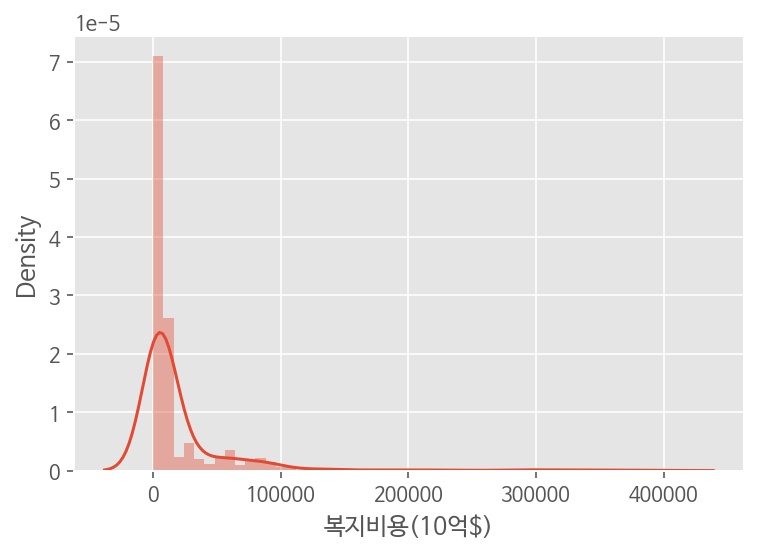

In [45]:
_ = sns.distplot(df_welfare['복지비용(10억$)'])

In [46]:
df_welfare.describe(include = 'object')

,대륙,국가,공통국가여부,key_gdp
count,893,893,893,893
unique,5,37,2,805
top,유럽,소계,공통,소계1998
freq,591,110,608,5


In [47]:
569 / len(df_welfare.loc[df_welfare['대륙']=='유럽', '국가'].unique())
# 유럽은 그냥 국가가 많아서 그런걸로

21.074074074074073

##### 결측치

In [48]:
# 결측치 전체
df_welfare.isnull().sum()

대륙               0
국가               0
공통국가여부           0
연도               0
값(% of gdp)    110
전년대비증감         112
key_gdp          0
GDP(10억$)      110
복지비용(10억$)     110
dtype: int64

In [49]:
df_wel_na = df_welfare.loc[df_welfare['전년대비증감'].isnull(), ['국가', '값(% of gdp)','전년대비증감']]
df_wel_na['국가'].value_counts()

소계       110
에스토니아      1
헝가리        1
Name: 국가, dtype: int64

In [50]:
# 소계 결측치 비율 확인
df_welfare[df_welfare['국가'] == '소계'].isnull().mean() # 1.0

대륙             0.0
국가             0.0
공통국가여부         0.0
연도             0.0
값(% of gdp)    1.0
전년대비증감         1.0
key_gdp        0.0
GDP(10억$)      1.0
복지비용(10억$)     1.0
dtype: float64

In [51]:
# 소계 외 2행 : 에스토니아, 헝가리 (전년증감) 결측치 탐구 
df_welfare[ (df_welfare['전년대비증감'].isnull()) & (df_welfare['국가'].isin(['에스토니아','헝가리'])) ]

,대륙,국가,공통국가여부,연도,값(% of gdp),전년대비증감,key_gdp,GDP(10억$),복지비용(10억$)
349,유럽,에스토니아,공통,1999,15.2,NaN,에스토니아1999,5.8,88.16
458,유럽,헝가리,공통,1999,20.9,NaN,헝가리1999,49.1,1026.19


In [52]:
# 전년 대비 증감이 null값 - 가설 : 전년 데이터가 없다 - if true : 0으로 채워줌 => 가설 True인 거 확인 
df_welfare.loc[df_welfare['국가'] == '에스토니아', '연도'].min() , df_welfare.loc[df_welfare['국가'] == '헝가리', '연도'].min() 

(1999, 1999)

In [53]:
# 결측치 탐색 결론 :  전년대비 증감 NaN -fillna > 소계 삭제
df_welfare['전년대비증감'] = df_welfare['전년대비증감'].fillna(0)
# 결측치 2행 처리 후, 소계 마저 삭제해줌
df_welfare = df_welfare.dropna(how = 'any')
df_welfare.isnull().sum()

대륙             0
국가             0
공통국가여부         0
연도             0
값(% of gdp)    0
전년대비증감         0
key_gdp        0
GDP(10억$)      0
복지비용(10억$)     0
dtype: int64

##### 중복값

In [54]:
df_welfare.duplicated().sum()

0

##### 필요없는 데이터 버리기

#### EDA 및 시각화

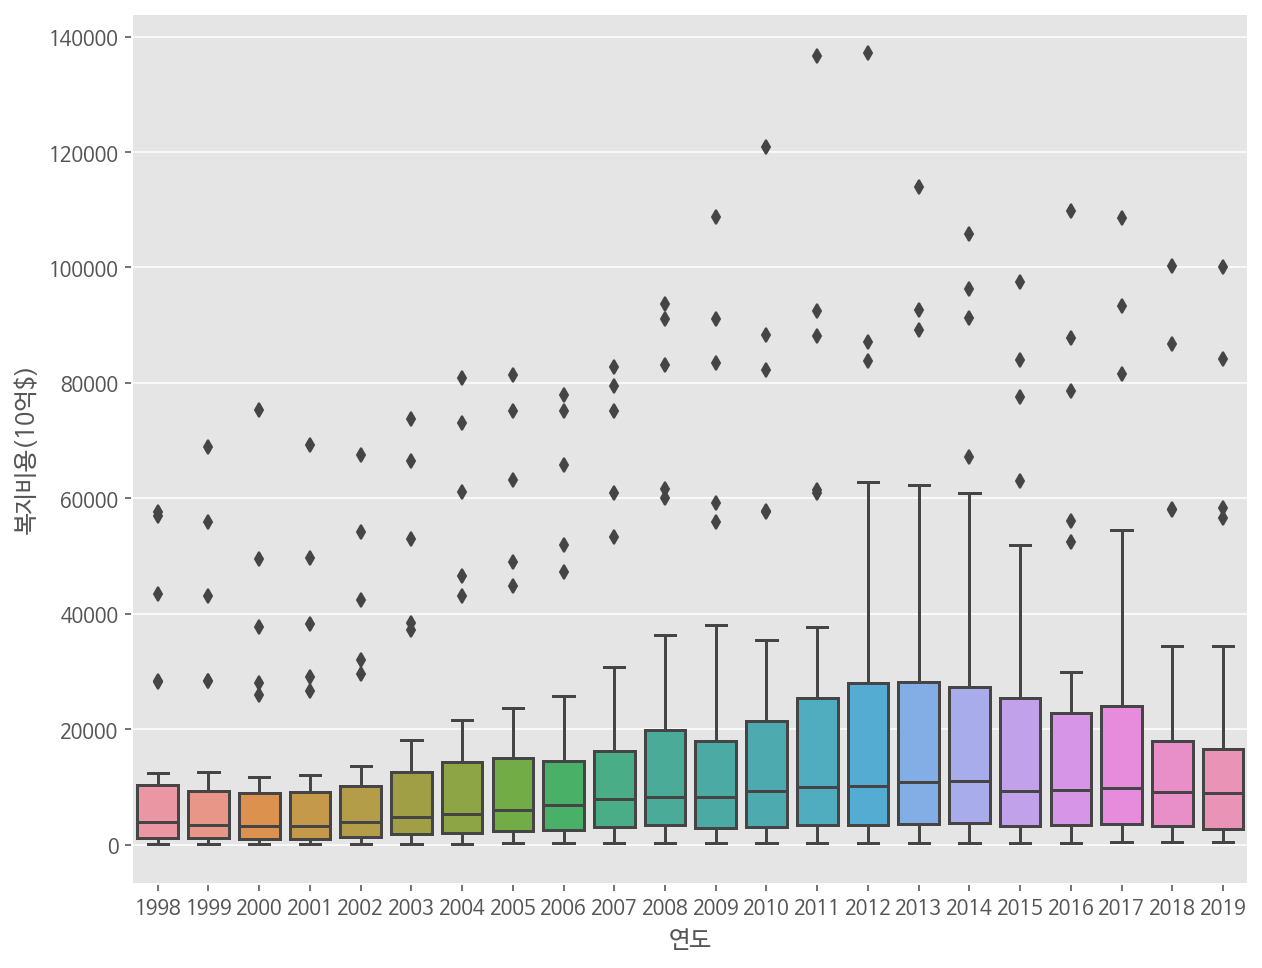

In [55]:
plt.figure(figsize = (10,8))
sns.boxplot(data=df_welfare[df_welfare['공통국가여부']=='공통'], x='연도', y='복지비용(10억$)', )

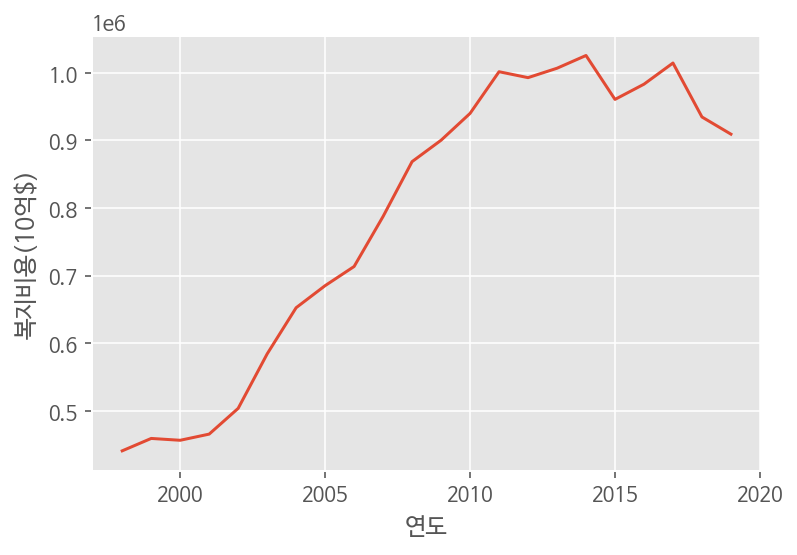

In [56]:
#  title = '연도 별 공공사회복지비용 - 전세계 총액'
_ = sns.lineplot(data = df_welfare, x = '연도', y = '복지비용(10억$)', estimator = 'sum', ci = None, )

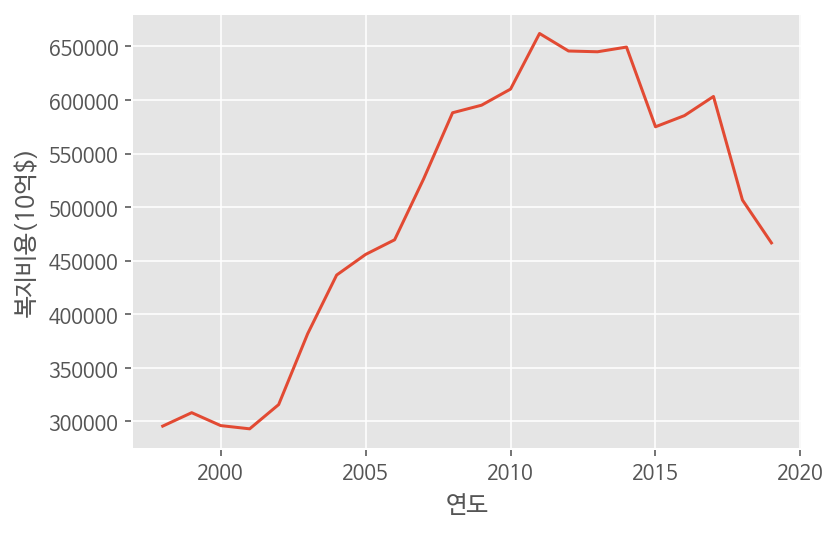

In [57]:
#  title = '연도 별 공공사회복지비용 - 공통국가 대상 총액'
_ = sns.lineplot(data = df_welfare[df_welfare['공통국가여부']=='공통'], x = '연도', y = '복지비용(10억$)', estimator = np.sum, ci = None, )

In [58]:
#  title = '연도 별 공공사회복지비용 - 국가별'
# _ = sns.lineplot(data = df_welfare, x = '연도', y = '값', hue = '국가', estimator = np.sum, ci = None, )
px.line(data_frame = df_welfare[df_welfare['공통국가여부']=='공통'], x = '연도', y = '복지비용(10억$)', color = '국가',
            title = '연도 별 공공사회복지비용 - 국가별',  )

그런데 어떤 복지국가로 갈 것인가? 이탈리아나 그리스는 정부의 복지지출 가운데 상당 부분이 연금과 의료에 쏠려 있다. 덴마크와 스웨덴은 연금과 의료 지출이 통제되어 상대적으로 적은 편이다. 그 대신, 다른 사회서비스나 노동 연령대에 대한 소득지원 등에 쓰는 돈이 많다.
https://www.sisain.co.kr/news/articleView.html?idxno=46915

In [59]:
#  title = '연도 별 공공사회복지비용 - 대륙별'
# _ = sns.lineplot(data = df_welfare, x = '연도', y = '값', hue = '국가', estimator = np.sum, ci = None, )
df_cont = df_welfare[df_welfare['공통국가여부']=='공통'].groupby(by = ['연도','대륙'], as_index = False)['복지비용(10억$)'].sum()
px.line(data_frame = df_cont, x = '연도', y = '복지비용(10억$)', color = '대륙')

In [60]:
# 이상해서 연도별 데이터 수 / 값의 총합 확인해봄
# 1. 2007-8년 전후로 확 증가하는 이유: 
# 2. 2013년 기점으로 다시 감소하는 이유:
# 3. 2018-19년 폭락 이유: 
#   - 데이터 수집량 자체는 두 세 국가밖에 차이 안 남 : 근데 걔네가 희대의 복지국가들인 게 문제야 
#   - 분석 결과 메인 요인이 데이터 수집 국가 차이 기인임
df_welfare.groupby(by = '연도')['국가'].count() 

연도
1998    34
1999    36
2000    36
2001    36
2002    36
2003    36
2004    36
2005    36
2006    36
2007    36
2008    36
2009    36
2010    36
2011    36
2012    36
2013    36
2014    36
2015    36
2016    36
2017    36
2018    34
2019    31
Name: 국가, dtype: int64

###### 2017년도 > 18년도 : 그래프 추세 감소 원인 확인

In [61]:
# 17-> 18년도 제외 국가
set(df_welfare.loc[df_welfare['연도']==2017, '국가'].unique()) - set(df_welfare.loc[df_welfare['연도']==2018, '국가'].unique())

{'오스트레일리아', '일본'}

In [62]:
# 17 - 18년도 감소 총액
sum_2017 = df_welfare.loc[df_welfare['연도']==2017, '복지비용(10억$)'].sum() 
sum_2018 = df_welfare.loc[df_welfare['연도']==2018, '복지비용(10억$)'].sum() 
sum_2017 - sum_2018

79817.2799999998

In [63]:
# 해당 두 나라 총 비용
aus_jp_2017 = df_welfare.loc[(df_welfare['연도']==2017) & (df_welfare['국가'].isin(['오스트레일리아', '일본'])),'복지비용(10억$)'].sum()
aus_jp_2017

130729.51

In [64]:
# 17 - 18년도 감소 총액 대비 비율
aus_jp_2017 / (sum_2017- sum_2018) * 100

163.78597466613786

In [65]:
# 저 두 나라 비중 : 17년도 전체 13퍼밖에 안 되지만, 감소액 총량보다 큼 : 그래프 감소 추이는 그냥 데이터 집계 국가의 변화 차이
aus_jp_2017 / sum_2017 * 100

12.885054181988979

In [66]:
# 그럼 오히려 증가한 나라는 어딘데? => 거의 다 :)
df_1718 = df_welfare[(df_welfare['연도'].isin([2017,2018])) & (df_welfare['공통국가여부'] =='공통')]
df_1718 = df_1718[(df_1718['국가']!='오스트레일리아') & (df_1718['국가']!='일본')].sort_values(by = 'key_gdp').reset_index(drop = True)
for index in df_1718.index :
    if df_1718.loc[index, '연도'] == 2017 :
        df_1718.loc[index, '전년대비증감(10억$)'] = 0
    else :
        df_1718.loc[index, '전년대비증감(10억$)'] =  df_1718.loc[index,'복지비용(10억$)']-df_1718.loc[index-1,'복지비용(10억$)']
df_1718.head(11)

,대륙,국가,공통국가여부,연도,값(% of gdp),전년대비증감,key_gdp,GDP(10억$),복지비용(10억$),전년대비증감(10억$)
0,유럽,그리스,공통,2017,24.7,-0.9,그리스2017,199.6,4930.12,0.00
1,유럽,그리스,공통,2018,24.1,-0.5,그리스2018,212.1,5111.61,181.49
2,유럽,네덜란드,공통,2017,16.6,-0.9,네덜란드2017,831.8,13807.88,0.00
3,유럽,네덜란드,공통,2018,16.2,-0.4,네덜란드2018,913.6,14800.32,992.44
4,유럽,노르웨이,공통,2017,25.2,-0.8,노르웨이2017,398.4,10039.68,0.00
5,유럽,노르웨이,공통,2018,24.4,-0.8,노르웨이2018,437.0,10662.80,623.12
6,오세아니아,뉴질랜드,공통,2017,18.6,-0.5,뉴질랜드2017,207.0,3850.20,0.00
7,오세아니아,뉴질랜드,공통,2018,19.4,0.8,뉴질랜드2018,212.2,4116.68,266.48
8,유럽,덴마크,공통,2017,29.2,-0.1,덴마크2017,332.1,9697.32,0.00
9,유럽,덴마크,공통,2018,28.7,-0.5,덴마크2018,356.9,10243.03,545.71


In [67]:
# 그럼 오히려 증가한 나라는 어딘데?
df_1718.loc[df_1718['전년대비증감(10억$)'] > 0.00, '전년대비증감(10억$)'].sum(), df_1718.loc[df_1718['전년대비증감(10억$)'] > 0.00, '국가'].unique()

(34048.740000000034,
 array(['그리스', '네덜란드', '노르웨이', '뉴질랜드', '덴마크', '독일', '라트비아', '룩셈부르크', '벨기에',
        '스웨덴', '스페인', '슬로바키아', '슬로베니아', '아이슬란드', '아일랜드', '에스토니아', '영국',
        '오스트리아', '이탈리아', '체코', '캐나다', '포르투갈', '프랑스', '핀란드', '한국', '헝가리'],
       dtype=object))

In [68]:
df_1718.loc[df_1718['전년대비증감(10억$)'] > 0.00, ['대륙', '국가', '복지비용(10억$)', '전년대비증감(10억$)']].groupby(by = '대륙').sum()

,복지비용(10억$),전년대비증감(10억$)
대륙,,
북아메리카,30994.20,1306.80
아시아,18632.16,2236.83
오세아니아,4116.68,266.48
유럽,452926.66,30238.63


###### 2018년도 > 19년도 : 그래프 추세 감소 원인 확인

In [69]:
# 18 - 19년도 제외 국가
set(df_welfare.loc[df_welfare['연도']==2018, '국가'].unique()) - set(df_welfare.loc[df_welfare['연도']==2019, '국가'].unique())


{'뉴질랜드', '스위스', '캐나다'}

In [70]:
# 18 - 19년도 감소 총액
sum_2019 = df_welfare.loc[df_welfare['연도']==2019, '복지비용(10억$)'].sum() 
sum_2018 - sum_2019

25415.520000000135

In [71]:
# 해당 세 나라 총 비용
nz_swit_ca_2018 = df_welfare.loc[(df_welfare['연도']==2018) & (df_welfare['국가'].isin(['뉴질랜드', '스위스', '캐나다'])),'복지비용(10억$)'].sum()
nz_swit_ca_2018

47400.409999999996

In [72]:
# 18 - 19년도 감소 총액 대비 비율
nz_swit_ca_2018 / (sum_2018- sum_2019) * 100


186.501830377658

In [73]:
# 저 세 나라 비중 : 18년도 전체 5퍼밖에 안 되지만, 감소액 총액보다 많음 : 
# 이 말은, 감소액은 순전히 세 복지국가를 제외하면서 생긴 변화고. 오히려 다른 나라 혹은 외부 요인에서 증가 요인이 존재한다는 것.# 약간 코로나 생각하면 늘 법함 근데
nz_swit_ca_2018 / sum_2018 * 100


5.070835644876232

In [74]:
# 그럼 오히려 증가한 나라는 어딘데?
df_1819 = df_welfare[(df_welfare['연도'].isin([2019,2018])) & (df_welfare['공통국가여부'] =='공통')]
df_1819 = df_1819[(df_1819['국가']!='뉴질랜드') & (df_1819['국가']!='스위스')& (df_1819['국가']!='캐나다')].sort_values(by = 'key_gdp').reset_index(drop = True)
for index in df_1819.index :
    if df_1819.loc[index, '연도'] == 2018 :
        df_1819.loc[index, '전년대비증감(10억$)'] = 0
    else :
        df_1819.loc[index, '전년대비증감(10억$)'] =  df_1819.loc[index,'복지비용(10억$)']-df_1819.loc[index-1,'복지비용(10억$)']
df_1819.head(4)

,대륙,국가,공통국가여부,연도,값(% of gdp),전년대비증감,key_gdp,GDP(10억$),복지비용(10억$),전년대비증감(10억$)
0,유럽,그리스,공통,2018,24.1,-0.5,그리스2018,212.1,5111.61,0.00
1,유럽,그리스,공통,2019,24.0,-0.1,그리스2019,205.3,4927.20,-184.41
2,유럽,네덜란드,공통,2018,16.2,-0.4,네덜란드2018,913.6,14800.32,0.00
3,유럽,네덜란드,공통,2019,16.1,-0.1,네덜란드2019,907.1,14604.31,-196.01


In [75]:
# 그럼 오히려 증가한 나라는 어딘데?
df_1819.loc[df_1819['전년대비증감(10억$)'] > 0.00, '전년대비증감(10억$)'].sum(), df_1819.loc[df_1819['전년대비증감(10억$)'] > 0.00, '국가'].unique()

(2168.570000000004,
 array(['라트비아', '룩셈부르크', '스페인', '슬로바키아', '슬로베니아', '아이슬란드', '아일랜드', '에스토니아',
        '영국', '체코', '한국'], dtype=object))

In [76]:
df_1819.loc[df_1819['전년대비증감(10억$)'] > 0.00, ['대륙', '국가', '복지비용(10억$)', '전년대비증감(10억$)']].groupby(by = '대륙').sum()

,복지비용(10억$),전년대비증감(10억$)
대륙,,
아시아,20142.20,1510.04
유럽,108976.57,658.53


In [77]:
# 그럼 공통국가가 ['오스트레일리아', '일본', '캐나다', '뉴질랜드', '스위스'] 얼마나 포함함? 
len(country_intersection), len(country_intersection)-len(['오스트레일리아', '일본', '캐나다', '뉴질랜드', '스위스'])
# 오 다 포함함. 그럼 비슷한 추세를 보이는 게 이유가 설명됨.

(28, 23)

###### 대상 외 국가 추세도 한 번 확인해 봄

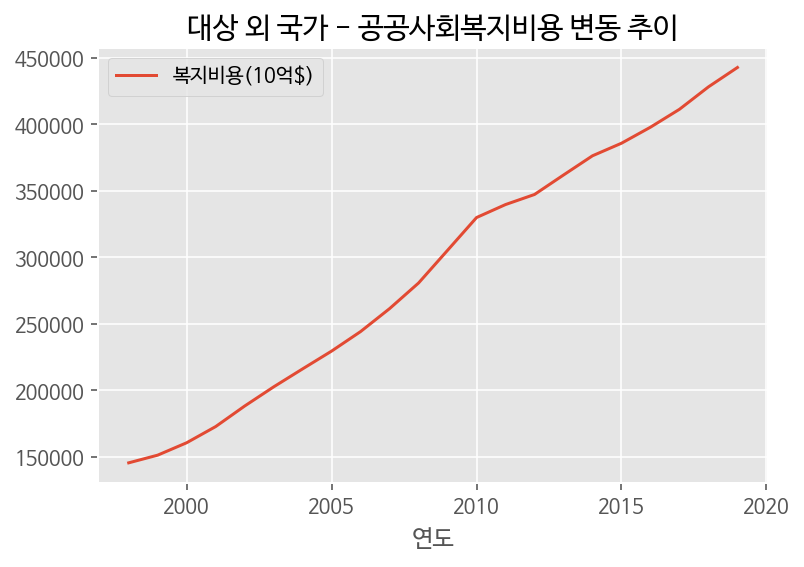

In [78]:
sum_global = pd.DataFrame(df_welfare.groupby(by = '연도')['복지비용(10억$)'].sum())
sum_common = pd.DataFrame(df_welfare[df_welfare['공통국가여부']=='공통'].groupby(by = '연도')['복지비용(10억$)'].sum())
(sum_global - sum_common).plot(title = '대상 외 국가 - 공공사회복지비용 변동 추이')


##### 기초 기술 통계

#### 데이터 EDA - 사회복지서비스 지출

##### 기본정보 확인

In [79]:
df_service.shape

(5868, 10)

In [80]:
df_service.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5868 entries, 0 to 5867
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대륙            5868 non-null   object 
 1   국가            5868 non-null   object 
 2   공통국가여부        5868 non-null   object 
 3   항목구분          5868 non-null   object 
 4   연도            5868 non-null   int64  
 5   값(백만 자국화폐)    4902 non-null   float64
 6   전년대비증감        4759 non-null   float64
 7   key_currency  5868 non-null   object 
 8   환율(자국화폐단위/$)  2826 non-null   float64
 9   서비스비용(백만$)    2826 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 504.3+ KB


##### 결측치

In [81]:
df_service_common = df_service[(df_service['공통국가여부'] == '공통') &(df_service['연도'] <= 2019)]
df_service_common.shape

(3788, 10)

In [82]:
df_service_common.isnull().sum()

대륙                 0
국가                 0
공통국가여부             0
항목구분               0
연도                 0
값(백만 자국화폐)         0
전년대비증감            93
key_currency       0
환율(자국화폐단위/$)    1870
서비스비용(백만$)      1870
dtype: int64

In [83]:
df_service_common.sample(3)

,대륙,국가,공통국가여부,항목구분,연도,값(백만 자국화폐),전년대비증감,key_currency,환율(자국화폐단위/$),서비스비용(백만$)
4694,유럽,슬로베니아,공통,보건 당기 지출,2009,3096.0,118.0,2009슬로베니아,NaN,NaN
2591,유럽,프랑스,공통,보건 당기 지출,1999,135335.0,4760.0,1999프랑스,NaN,NaN
3363,유럽,아일랜드,공통,치료 및 재활 치료,2018,12543.0,785.0,2018아일랜드,NaN,NaN


In [84]:
# 아 환율 데이터에 아예 값 자체가 없어서, 처음에 결측치 탐구했을 때는 안 잡히고 -> merge한 애에서 잡히는 거네
currency_rate[currency_rate['key_currency'].astype(str).str.contains('핀란드')]

,key_currency,환율(자국화폐단위/$)
15,1998핀란드,5.34


In [85]:
df_service_common.loc[df_service_common['환율(자국화폐단위/$)'].isnull(), '국가'].unique()
# 다 유로화 사용하는 국가들인 거 알 수 있음

array(['오스트리아', '벨기에', '에스토니아', '핀란드', '프랑스', '독일', '그리스', '아일랜드', '이탈리아',
       '라트비아', '룩셈부르크', '네덜란드', '포르투갈', '슬로바키아', '슬로베니아', '스페인'],
      dtype=object)

In [86]:
df_service_common.loc[(df_service_common['대륙']=='유럽')&(~df_service_common['환율(자국화폐단위/$)'].isnull()), '국가'].value_counts()
# 덴마크 기준으로 환율 빈 애들 넣어주면 됨

덴마크      154
헝가리      154
아이슬란드    149
체코       147
노르웨이     146
스웨덴      145
에스토니아     84
라트비아      74
영국        64
슬로바키아     61
슬로베니아     37
스페인        7
네덜란드       7
오스트리아      7
독일         7
프랑스        7
핀란드        7
이탈리아       4
그리스        3
룩셈부르크      1
벨기에        1
포르투갈       1
아일랜드       1
Name: 국가, dtype: int64

In [87]:
df_service_common = df_service_common.reset_index(drop = True)
df_service_common.head(3)

,대륙,국가,공통국가여부,항목구분,연도,값(백만 자국화폐),전년대비증감,key_currency,환율(자국화폐단위/$),서비스비용(백만$)
0,아시아,한국,공통,보건 당기 지출,1998,19631167.0,495798.0,1998한국,1394.97,14072.82
1,아시아,한국,공통,보건 당기 지출,1999,22747522.0,3116355.0,1999한국,1188.65,19137.28
2,아시아,한국,공통,보건 당기 지출,2000,25398063.0,2650541.0,2000한국,1131.12,22453.91


In [88]:
df_service_common.loc[index, '환율(자국화폐단위/$)']

1290.99

In [89]:
df_service_common.loc[df_service_common['환율(자국화폐단위/$)'].isnull(), 'key_currency_ext']= df_service_common['연도'].astype(str)+"덴마크"
df_service_common.loc[df_service_common['key_currency_ext'].isnull(), 'key_currency_ext'] = df_service_common['key_currency']



In [90]:
df_service_common = df_service_common.merge(right = currency_rate, how = 'left', left_on = 'key_currency_ext', right_on = 'key_currency')


In [91]:
del df_service_common['환율(자국화폐단위/$)_x']
del df_service_common['서비스비용(백만$)']
del df_service_common['key_currency_y']

In [92]:
df_service_common.columns = ['대륙', '국가', '공통국가여부', '항목구분', '연도', '값(백만 자국화폐)', '전년대비증감',
       'key_currency_x', 'key_currency_ext', '환율(자국화폐단위/$)']

In [93]:
df_service_common['서비스비용(백만$)'] = round(df_service_common['값(백만 자국화폐)']/df_service_common['환율(자국화폐단위/$)'],2)
df_service_common.sample(2)

,대륙,국가,공통국가여부,항목구분,연도,값(백만 자국화폐),전년대비증감,key_currency_x,key_currency_ext,환율(자국화폐단위/$),서비스비용(백만$)
2469,유럽,룩셈부르크,공통,의료품,2008,313.0,8.0,2008룩셈부르크,2008덴마크,5.10,61.37
1283,유럽,핀란드,공통,의료품,2011,2709.0,43.0,2011핀란드,2011덴마크,5.37,504.47


In [94]:
df_service_common[df_service_common['환율(자국화폐단위/$)'].isnull()].sum()

대륙                  0.0
국가                  0.0
공통국가여부              0.0
항목구분                0.0
연도                  0.0
값(백만 자국화폐)          0.0
전년대비증감              0.0
key_currency_x      0.0
key_currency_ext    0.0
환율(자국화폐단위/$)        0.0
서비스비용(백만$)          0.0
dtype: float64

##### 중복값

In [95]:
df_service_common.duplicated().sum()

0

##### 필요없는 데이터 버리기

In [96]:
# del df_service_common['key_currency_y']

#### EDA 및 시각화

In [97]:
df_service_common['항목구분'].unique().tolist()

['보건 당기 지출',
 '치료 및 재활 치료',
 '장기 치료',
 '보건 보조 서비스',
 '의료품',
 '예방치료',
 '정부의료체계 및 재정행정']

In [98]:
# px 그릴 거 집계
px_cont = df_service_common.groupby(by = ['연도','대륙'], as_index = False )['서비스비용(백만$)'].sum()
px_nation = df_service_common.groupby(by = ['연도','국가'], as_index = False )['서비스비용(백만$)'].sum()

In [99]:
px.line(data_frame = px_cont,x= '연도', y = '서비스비용(백만$)',  color = '대륙', title = '대륙 별 사회복지서비스 비용(백만$)')

In [100]:
px.bar(data_frame = px_cont, 
       x= '연도', y = '서비스비용(백만$)',  color = '대륙', title = '국가 별 사회복지서비스 비용(백만$)',)

In [101]:
# 공공사회복지 지출처럼, 데이터 집계 풀에 차이가 있는지 = 없음 -> 따라서 말 그대로 서비스비용에 차이가 생김
# 18 -> 19년도 제외 국가
set(df_service_common.loc[df_service_common['연도']==2018, '국가'].unique()) - set(df_service_common.loc[df_service_common['연도']==2019, '국가'].unique())

set()

In [102]:
df_ser_18 = df_service_common[df_service_common['연도']==2018]
df_ser_19 = df_service_common[df_service_common['연도']==2019]

In [103]:
# 아시아 집계 국가 수
set(df_ser_18.loc[df_ser_18['대륙']=='아시아', '국가'].unique()) - set(df_ser_19.loc[df_ser_19['대륙']=='아시아', '국가'].unique())

set()

In [104]:
# 유럽 집계 국가 수
set(df_ser_18.loc[df_ser_18['대륙']=='유럽', '국가'].unique()) - set(df_ser_19.loc[df_ser_19['대륙']=='유럽', '국가'].unique())

set()

In [105]:
# 오세아니아 집계 국가 수
set(df_ser_18.loc[df_ser_18['대륙']=='오세아니아', '국가'].unique()) - set(df_ser_19.loc[df_ser_19['대륙']=='오세아니아', '국가'].unique())

set()

결론 : 집계한 국가에는 차이가 없다. 그렇다면 말 그대로 복지 서비스가 감소한 것임
-> 국가 별/항목 별 복지서비스 지출 증감 분석

###### 국가 별 사회복지서비스 총액 증감 분석

In [106]:
px.line(data_frame = px_nation,x= '연도', y = '서비스비용(백만$)',  color = '국가', title = '국가 별 사회복지서비스 비용(백만$)')

In [107]:
px.bar(data_frame = px_nation, 
       x= '연도', y = '서비스비용(백만$)',  color = '국가', title = '국가 별 사회복지서비스 비용(백만$)',)

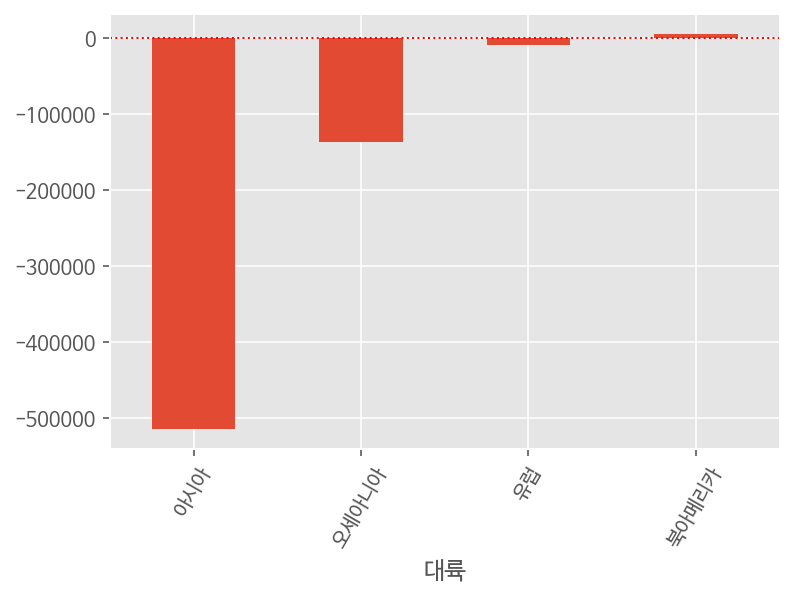

In [108]:
# 18 -> 19 전체 증감 분석
cont_temp = (df_ser_19.groupby('대륙')['서비스비용(백만$)'].sum() - df_ser_18.groupby('대륙')['서비스비용(백만$)'].sum()
).sort_values(ascending = True)

cont_temp.plot(kind = 'bar', rot = 60)
# plt.plot(df_ser_cat_1819)
plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
plt.show()

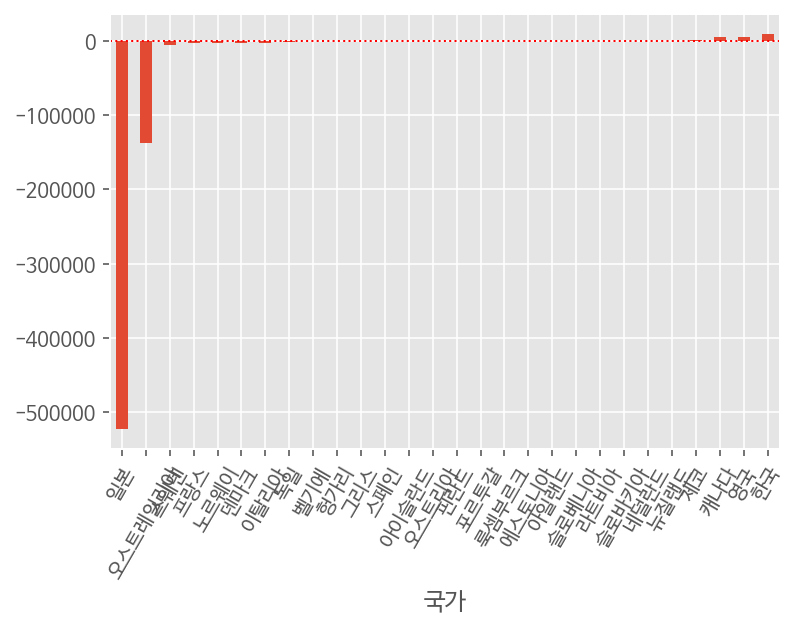

In [109]:
# 18 -> 19 전체 증감 분석
total_temp = (df_ser_19.groupby('국가')['서비스비용(백만$)'].sum() - df_ser_18.groupby('국가')['서비스비용(백만$)'].sum()
).sort_values(ascending = True)

total_temp.plot(kind = 'bar', rot = 60)
# plt.plot(df_ser_cat_1819)
plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
plt.show()

In [110]:
# 북아메리카     5614.99
na_temp = (df_ser_19[df_ser_19['대륙']=='북아메리카'].groupby('국가')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['대륙']=='북아메리카'].groupby('국가')['서비스비용(백만$)'].sum()
).sort_values(ascending = True)
na_temp
# na_temp.plot(kind = 'bar', rot = 60)
# # plt.plot(df_ser_cat_1819)
# plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
# plt.show()

국가
캐나다    5614.99
Name: 서비스비용(백만$), dtype: float64

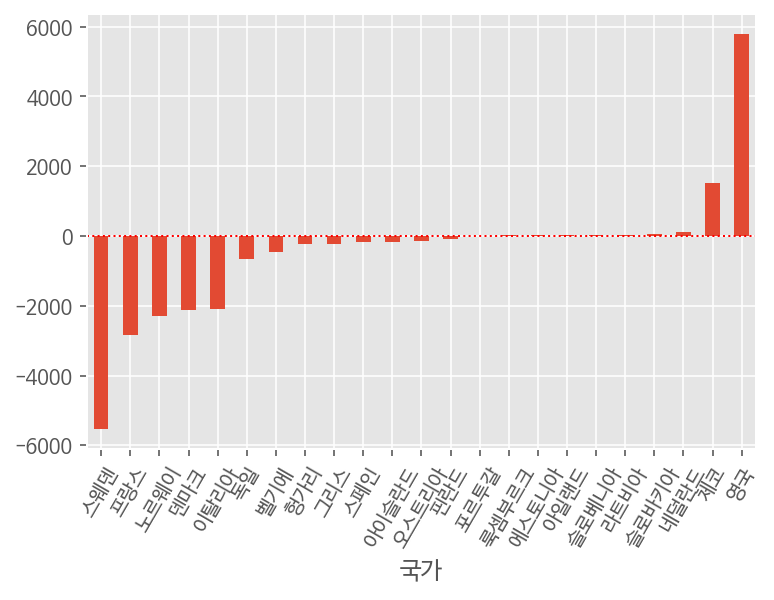

In [111]:
# 유럽         -9382.09
eur_temp = (df_ser_19[df_ser_19['대륙']=='유럽'].groupby('국가')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['대륙']=='유럽'].groupby('국가')['서비스비용(백만$)'].sum()
).sort_values(ascending = True)

eur_temp.plot(kind = 'bar', rot = 60)
# plt.plot(df_ser_cat_1819)
plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
plt.show()

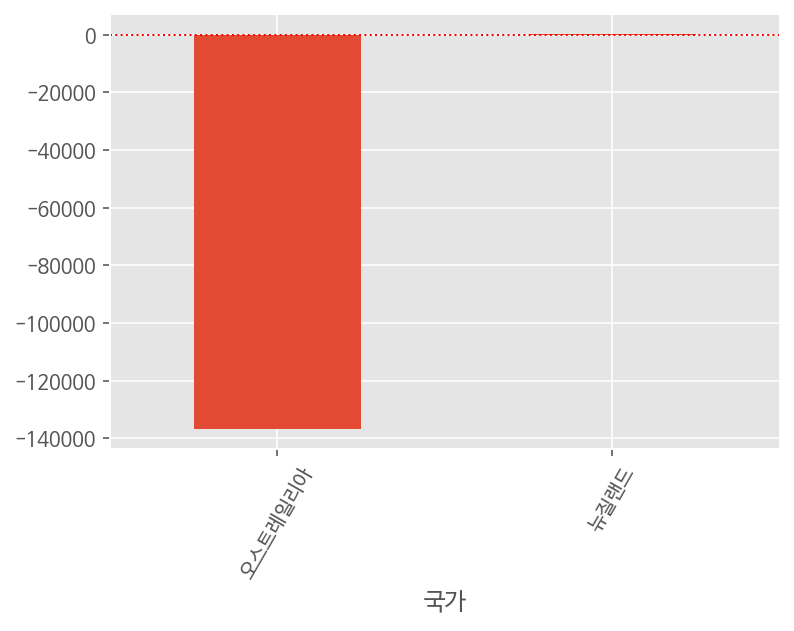

In [112]:
# 오세아니아    -136760.98
ose_temp = (df_ser_19[df_ser_19['대륙']=='오세아니아'].groupby('국가')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['대륙']=='오세아니아'].groupby('국가')['서비스비용(백만$)'].sum()
).sort_values(ascending = True)

ose_temp.plot(kind = 'bar', rot = 60)
# plt.plot(df_ser_cat_1819)
plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
plt.show()

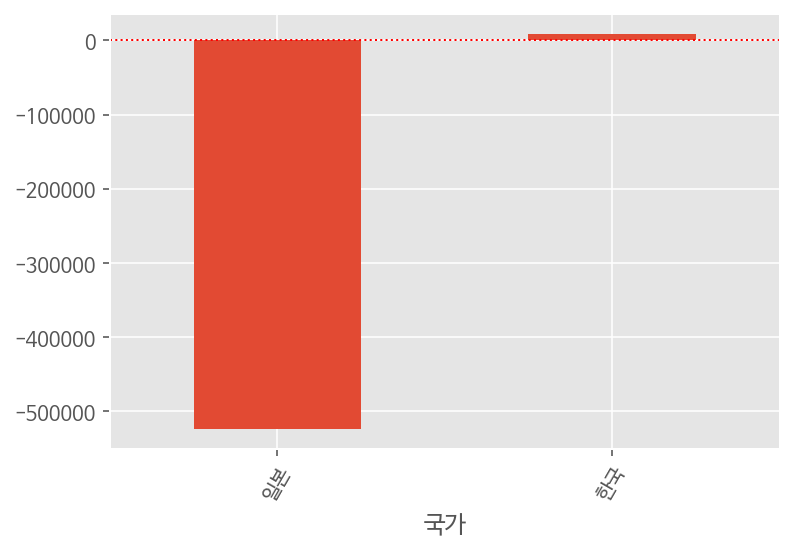

In [113]:
# 아시아      -514494.17
asia_temp = (df_ser_19[df_ser_19['대륙']=='아시아'].groupby('국가')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['대륙']=='아시아'].groupby('국가')['서비스비용(백만$)'].sum()
).sort_values(ascending = True)

asia_temp.plot(kind = 'bar', rot = 60)
# plt.plot(df_ser_cat_1819)
plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
plt.show()

###### 분석항목 별 사회복지서비스 총액 증감 분석

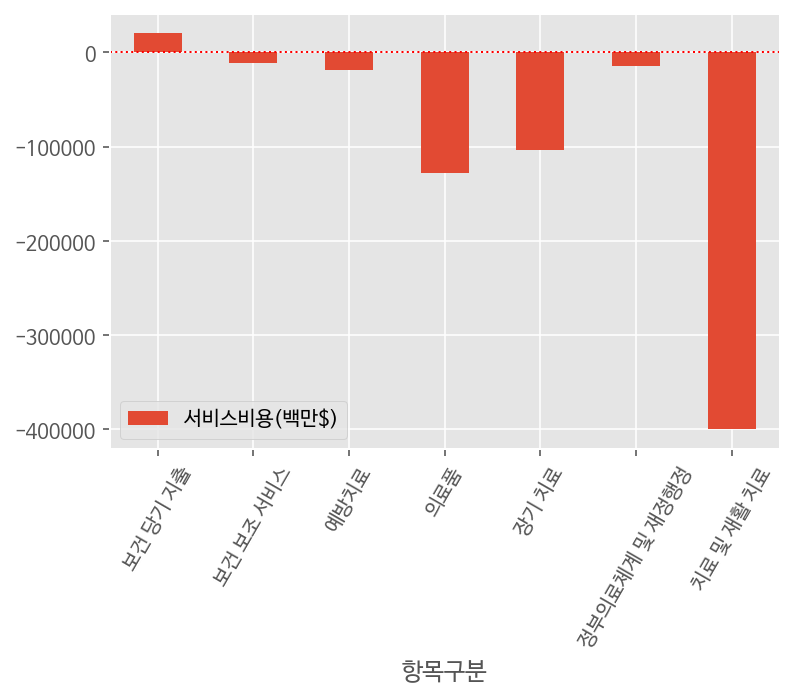

In [114]:
# 18 -> 19 전체 증감 분석
df_ser_cat_1819 = pd.DataFrame(df_ser_19.groupby('항목구분')['서비스비용(백만$)'].sum() - df_ser_18.groupby('항목구분')['서비스비용(백만$)'].sum())

df_ser_cat_1819.plot(kind = 'bar', rot = 60)
# plt.plot(df_ser_cat_1819)
plt.axhline(y=0, color='r', linestyle=':', linewidth=1)
plt.show()

In [115]:
# 치료 및 재활 치료 항목 : 대륙 별 증감
df_ser_19[df_ser_19['항목구분']=='치료 및 재활 치료'].groupby('대륙')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['항목구분']=='치료 및 재활 치료'].groupby('대륙')['서비스비용(백만$)'].sum()

대륙
북아메리카       375.56
아시아     -302948.17
오세아니아          NaN
유럽        -3660.96
Name: 서비스비용(백만$), dtype: float64

In [116]:
# 치료 및 재활 치료 항목 : 국가 별 증감
df_ser_19[df_ser_19['대륙']=='아시아']
df_ser_18[df_ser_18['대륙']=='아시아']
# 이게 데이터 누락인지 / 혹은 정말 그 항목을 없앤 건지 모르겠지만, 일본 보건 당기 지출 제외하고 모든 복지서비스비용 데이터 없음 - 기인 감소

,대륙,국가,공통국가여부,항목구분,연도,값(백만 자국화폐),전년대비증감,key_currency_x,key_currency_ext,환율(자국화폐단위/$),서비스비용(백만$)
20,아시아,한국,공통,보건 당기 지출,2018,142740583.0,12670336.0,2018한국,2018한국,1100.58,129695.78
42,아시아,한국,공통,치료 및 재활 치료,2018,80505650.0,7747014.0,2018한국,2018한국,1100.58,73148.39
64,아시아,한국,공통,장기 치료,2018,18881943.0,2104390.0,2018한국,2018한국,1100.58,17156.36
86,아시아,한국,공통,보건 보조 서비스,2018,2216029.0,274906.0,2018한국,2018한국,1100.58,2013.51
108,아시아,한국,공통,의료품,2018,31307968.0,2229898.0,2018한국,2018한국,1100.58,28446.79
130,아시아,한국,공통,예방치료,2018,5073899.0,-97700.0,2018한국,2018한국,1100.58,4610.20
152,아시아,한국,공통,정부의료체계 및 재정행정,2018,4755094.0,411827.0,2018한국,2018한국,1100.58,4320.53
174,아시아,일본,공통,보건 당기 지출,2018,59781418.0,844463.0,2018일본,2018일본,110.42,541400.27
196,아시아,일본,공통,치료 및 재활 치료,2018,33762649.0,458966.0,2018일본,2018일본,110.42,305765.70
217,아시아,일본,공통,장기 치료,2018,11162686.0,330571.0,2018일본,2018일본,110.42,101092.97


In [117]:
# 의료품 항목 : 대륙 별 증감
df_ser_19[df_ser_19['항목구분']=='의료품'].groupby('대륙')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['항목구분']=='의료품'].groupby('대륙')['서비스비용(백만$)'].sum()

대륙
북아메리카       499.15
아시아     -105328.61
오세아니아          NaN
유럽        -1804.44
Name: 서비스비용(백만$), dtype: float64

In [118]:
# 장기치료 항목 : 대륙 별 증감
df_ser_19[df_ser_19['항목구분']=='장기 치료'].groupby('대륙')['서비스비용(백만$)'].sum() - df_ser_18[df_ser_18['항목구분']=='장기 치료'].groupby('대륙')['서비스비용(백만$)'].sum()

대륙
북아메리카       735.62
아시아     -100246.85
오세아니아          NaN
유럽        -1266.16
Name: 서비스비용(백만$), dtype: float64

결론: 감소한 한목 모두에 대해서, 대부분 아시아 감소폭이 메인 요인
- 일본이 보건 당기 지출 제외, 기타 항목 복지 서비스 데이터 없음
- 이유는 찾아봐야 함

In [119]:
# 일본에 대해서만 증감
df_ser_jp_temp = df_service_common.loc[(df_service_common['국가']=='일본'), ['항목구분', '연도', '서비스비용(백만$)']]
df_ser_jp_temp.head(3)

,항목구분,연도,서비스비용(백만$)
154,보건 당기 지출,1998,266758.75
155,보건 당기 지출,1999,318245.50
156,보건 당기 지출,2000,349487.69


In [120]:
px.line(data_frame = df_ser_jp_temp, x = '연도', y = '서비스비용(백만$)', color = '항목구분')

# 각 항목 별 전처리 완료 dataframe 파일 저장

In [122]:
df_welfare.to_csv("공공사회복지지출_raw_dataframe_220610.csv")
# df_insurance.to_csv("사회보험부담률_raw_dataframe_220610.csv")
df_service_common.to_csv("사회복지서비스지출_raw_dataframe_220610.csv")